In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X
np.random.seed(3141) # set seed

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.261903 -0.195564 -0.118952  0.508459  0.226598 -0.544555  0.183888   
  1  -1.082973 -0.303835  0.760778 -0.542671 -0.601598 -0.201768  0.234910   
  2  -0.110359 -0.679539  0.491245 -0.309772 -0.552727  0.036729 -0.673302   
  3  -0.010940  1.003427  0.412653  0.784238  0.014637  0.611269  0.323679   
  4  -0.073207 -0.370736 -0.005857 -0.833907 -0.096337 -0.714240  0.094026   
  5   0.896538  0.178065  0.186276  0.159529 -0.774354  0.192105 -0.657249   
  6   0.108513 -0.079120  0.302778 -1.047476 -0.155363  0.298648  0.749952   
  7   0.822284  0.636223  0.923465 -0.572504 -0.506166 -0.717440 -0.223074   
  8   0.525072  0.223879 -0.127802  0.066327 -0.159234  0.141032  0.280494   
  9  -1.277828 -0.001477 -0.402283 -0.981596 -0.366864 -1.113721 -0.432596   
  10  0.255616  1.049006  0.113948 -0.369794  0.326758  0.121641  0.531501   
  11 -0.459151 -0.429218  0.286828 -0.414682 -0.024168 -0.466549 -0.543770   
  12 -0.334370  0.435261 -0.027700  0.126514 -1.175591 -1.056230 -0.710277   
  13 -0.302661  0.646040  0.640180  0.042748 -0.113326 -0.220553  0.481621   
  14  0.266911 -0.335268 -0.778099 -0.531650 -0.574113 -0.360536 -0.546285   
  15 -0.448515 -0.798097 -0.722419 -1.081633  0.301170 -0.469064  0.682194   
  16  0.310542  0.377708 -0.825026  0.064748 -0.065031 -0.840901 -0.868081   
  17 -0.388185 -0.253031  0.031026 -0.182594  0.139518  0.217987 -0.102031   
  18 -1.896181 -1.335367 -1.954696 -0.318999 -0.873602 -0.982294 -0.421576   
  19 -0.610261 -0.472693 -1.016153  0.229175 -0.149479 -0.254136 -0.427090   
  20  0.354445  0.159904  0.464633  0.179123 -0.517307  0.405764 -0.164046   
  21 -0.311117  0.619567 -0.666270  0.080992 -0.850385  0.368533 -0.556263   
  22 -0.054551  0.268802 -1.092590 -0.479608 -0.151828  1.097881 -1.212572   
  23  0.290257  0.890970  0.981587 -0.206763 -0.074407 -0.288766 -0.863318   
  24  0.447506  1.025707  0.165442 -0.367202  0.179182  0.865451  0.204474   
1 0   0.085163  0.126914  0.793147  0.806835  0.348796 -0.183503  0.260567   
  1   0.640061  0.856448  0.372337 -0.083796  0.638544  0.118188 -1.805682   
  2   0.570709  0.343690  1.275316  0.302782 -0.119363  0.287774 -0.983988   
  3   1.025913  0.050668  0.337848  1.204428 -0.135959 -0.219208 -0.302827   
  4   1.672162  0.433178  0.199653 -0.120461  0.019282 -0.337269 -0.725652   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   1.694919  0.750048  0.314384  ... -0.205938 -0.996934 -1.136836   
  1   0.212844 -0.523743 -0.267547  ...  0.427573  0.303324  0.247826   
  2  -1.024604 -0.635283  0.005629  ...  0.094381 -0.922996 -2.054068   
  3  -0.557999  0.060568  0.607348  ...  0.698694  1.342992 -1.136089   
  4   0.435401  0.941408  0.260039  ... -0.149714 -0.164864 -0.756805   
  5  -0.198245 -0.003188 -0.094065  ...  0.705045  0.163243 -0.345162   
  6  -0.124667 -0.113644  0.006786  ...  1.024134 -0.904801  0.576899   
  7  -0.018359  0.239189  0.830245  ...  0.062526  0.085077 -0.026525   
  8   0.650861  0.556402 -0.217081  ...  0.245080  0.671400 -0.435076   
  9   0.671401 -0.173375  0.038081  ... -0.122195 -0.328467 -0.393734   
  10  1.098936  0.535221  0.177892  ... -0.263503 -0.555764 -1.593443   
  11  0.217462  0.158002  1.294238  ... -0.104150  0.405159 -0.699605   
  12  1.017577  0.823502 -0.287104  ...  1.022750 -0.873425  0.359529   
  13 -0.009104  0.788551 -0.335388  ... -1.037490 -0.409926  0.160269   
  14 -0.288788  0.231988  1.066750  ...  0.844182 -0.479060 -0.233906   
  15  0.596549  0.507988  1.497058  ...  0.273602 -0.659725 -0.447759   
  16 -0.362104 -0.258764 -0.031331  ... -0.123091  0.402909 -1.259463   
  17  1.189637 -0.075355 -0.112260  ...  0.178143 -0.958899 -0.614178   
  18  0.285829  0.771820 -0.433136  ...  1.536387 -0.681559 -0.678403   
  19 -0.088191 -0.671016  0.170206  ...  0.344147 -0.973939 -0.520261   
  20 -0.250802 -0.380517 -0.298236  ...  0.670892 -0.475977 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.197224  0.040051  29.892863  2.436427e-196  1.118727  1.275722


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



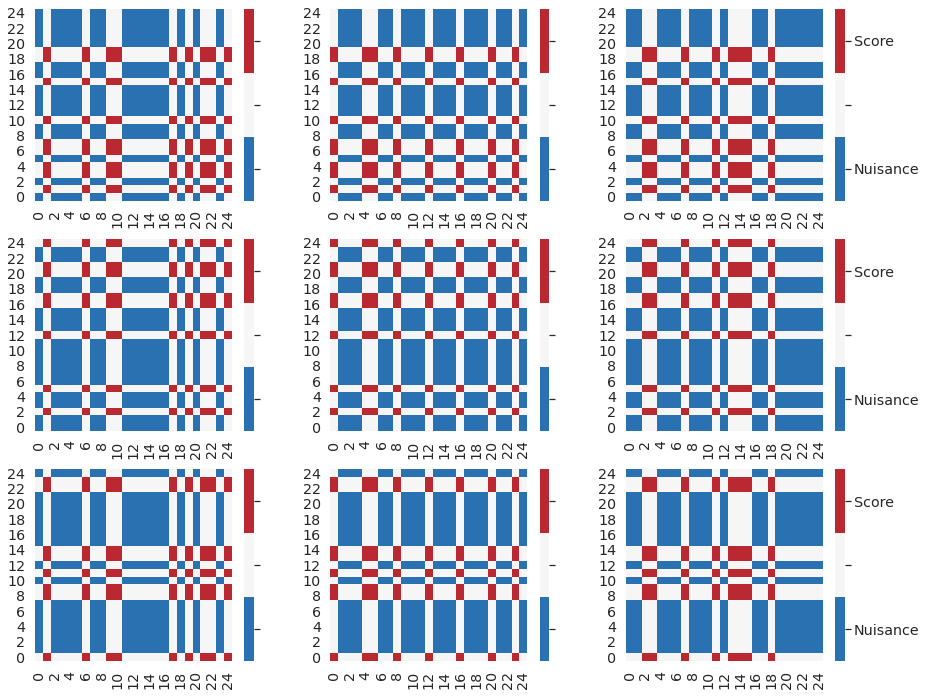

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N*M, 1]),
                  index = pd.MultiIndex.from_product([range(N), range(M)]),
                  columns=['value'])
    
    ind_array_train = [*this_split_ind[0]]
    ind_array_test = [*this_split_ind[1]]
    
    df.loc[ind_array_train, :] = -1.
    df.loc[ind_array_test, :] = 1.
    
    df_wide = df.reset_index().pivot(index="level_0", columns="level_1", values="value")
    df_wide.index.name=''
    df_wide.columns.name=''

    ax = sns.heatmap(df_wide, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



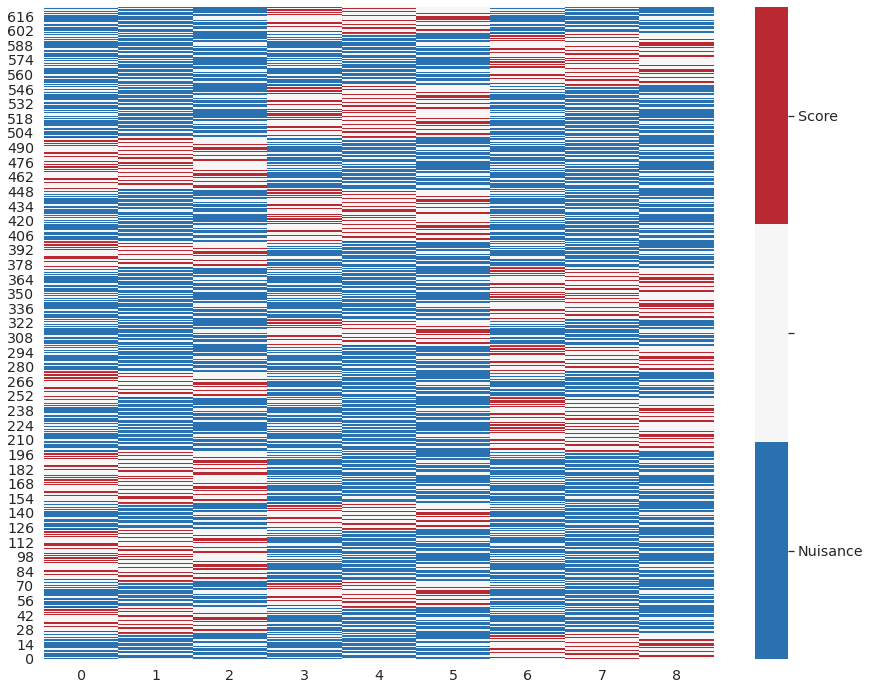

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])